In [3]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import json
import plotly.express as px
import webbrowser

from dash import Dash, dcc, html, Input, Output

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import manual_labeler_functions as man_lab_fun, general_functions as gf, files_paths as fp

## Function to analyzer the graphs of the selected video series

In [4]:
def PLOT_MEASURE_EXPLORER(df):

    port = 5000
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
    app = Dash(__name__, external_stylesheets=external_stylesheets)

    def open_browser():
    	webbrowser.open_new("http://localhost:{}".format(port))
          
    app.layout = html.Div([
        html.H4('Measure Explorer'),
        html.H6('Reference Signal'),
        html.I('Setting the frame interval range'),
        html.Br(),
        dcc.Input(id='input-init', type='number', min=df.index.min(), max=df.index.max(), value=df.index.min()),
        dcc.Input(id='input-end', type='number', value=df.index.max()),
        dcc.Graph(id="graph"),
        dcc.Checklist(
            id="checklist",
            options=df.columns,
            value=["m1", "m3"],
            inline=True
        ),
        dcc.Store(
        id='data-output',
        data=[{
            'measures': ["m1", "m3"],
            'init_label': df.index.min(),
            'end_label': df.index.max()
        }]
        ),
        html.Br(),
        html.Details([
        html.Summary('Input Parameters'),
        dcc.Markdown(id='clientside-figure-json')
        ])
    ])
    
    @app.callback(
        Output("graph", "figure"), 
        Input("checklist", "value"),
        Input("input-init", "value"),
        Input("input-end", "value"))
    def update_line_chart(measures, frame_init, frame_end):
        mask = df.columns.isin(measures)
        filtered_df = df.loc[frame_init:frame_end, mask]
        fig = px.line(filtered_df, width=900, height=400, labels={
                     "frame_seq": "<b>Frame number</b>",
                     "value": "<b>Amplitude (pixels)</b>",
                     "variable": "<b>Measures</b>"
                 },)
        data = measures
        fig.update_layout(
            plot_bgcolor='white',
            font_size=12,
        )
        fig.update_xaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            gridcolor='lightgrey',
        )
        fig.update_yaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            gridcolor='lightgrey',
        )
        return fig

    @app.callback(
        Output('data-output', 'data'),
        Input("checklist", "value"),
        Input("input-init", "value"),
        Input("input-end", "value"))
    def update_store_data(measures, frame_init, frame_end):
        mask = df.columns.isin(measures)
        filtered_df = df.loc[:,mask]
        return [{
            'measures': filtered_df.columns,
            'init_label': frame_init,
            'end_label': frame_end
        }]
    
    
    @app.callback(
        Output('clientside-figure-json', 'children'),
        Input('data-output', 'data')
    )
    def generated_data_json(data):
        return '```\n'+json.dumps(data, indent=2)+'\n```'
   
    if __name__ == '__main__':
        app.run_server(debug=True, port=port)

## Getting all the CSV files in the REF-Gold-Label

In [5]:
FILE_LIST_VD_INFO = gf.find_files_in_all_subdirectories([fp.DATASET_SEED], fp.VD_INFO)

## Generates an index with information about reference series.

In [6]:
INDEX_DT = man_lab_fun.CREATE_LABELED_INDEX(FILE_LIST_VD_INFO)

In [7]:
INDEX_DT

,link_video,duration_vid,total_frames,label_file_exist,path
video_id,,,,,
1,295xopXuU5E_happy_1,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000001
2,295xopXuU5E_happy_2,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000002
3,295xopXuU5E_happy_3,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000003
4,295xopXuU5E_neutral_1,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000004
5,295xopXuU5E_neutral_2,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000005
...,...,...,...,...,...
207,museu_da_pessoa_7_others_1,1.27,38,0,..\Dataset\REF-Gold-Label\VD_R_0000000207
208,museu_da_pessoa_7_others_2,1.27,38,0,..\Dataset\REF-Gold-Label\VD_R_0000000208
209,p9cvrKEFUhc_others_1,1.03,30,0,..\Dataset\REF-Gold-Label\VD_R_0000000209


## Labeling process

### Label the videos using the emotion on the name of the video

In [8]:
# As all used seed videos had their name like video_1_neutral_1.mp4 this code capture the emotion "neutral" and mark the video with that emotion

for i, video_file_path in enumerate(FILE_LIST_VD_INFO):
    video_file_directory = os.path.dirname(video_file_path)
    video_info_df = pd.read_csv(video_file_path)
    video_name = video_info_df['link_video'].values[0]
    current_emotion = video_name.split('_')[-2]

    # Read CSV data file
    VD_MEASURE_DT = man_lab_fun.READ_CSV_FILE(video_file_directory, fp.VD_MEASURE_L0)

    # set frames_seq as index
    VD_MEASURE_DT_V2 = VD_MEASURE_DT.set_index(pd.Index(VD_MEASURE_DT['frame_seq']))
    VD_MEASURE_DT_V2.drop(columns=["frame_seq", "video_id", "time_seconds"], inplace=True)

    VIDEO_EXT = '.mp4'

    path_video_file = os.path.join(fp.VIDEO_SOURCE_SEED, video_name + VIDEO_EXT)

    video_frames = man_lab_fun.LOAD_VIDEO_FRAMES(path_video_file)

    print('Creating Label File...')
    VD_MEASURE_DT['label_measures'] = str({})
    VD_LABELED_DT = VD_MEASURE_DT.copy()

    # Type the Begin and End frames you want to label (By default label the section with the selected frames above)
    init_frame_label = 0
    end_frame_label = len(VD_LABELED_DT) - 1

    # Prepare List and Dict
    label_measure_insert = ["m1", "m3", "m12", "e1", "e2"]

    # Just Insert
    VD_LABELED_DT = man_lab_fun.UPDATE_LABEL_DF(init_frame_label, end_frame_label, current_emotion, label_measure_insert, VD_LABELED_DT)

    VD_LABELED_DT.to_csv(os.path.join(video_file_directory, fp.VD_LABELED_L0))

    print("video_name", video_name)
    print("current_emotion", current_emotion)



Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Creating Label File...
video_name 295xopXuU5E_happy_1
current_emotion happy
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Creating Label File...
video_name 295xopXuU5E_happy_2
current_emotion happy
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Creating Label File...
video_name 295xopXuU5E_happy_3
current_emotion happy
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Creating Label File...
video_name 295xopXuU5E_neutral_1
current_emotion neutral
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Creating Label File...
video_name 295xopXuU5E_neutral_2
current_emotion neutral
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Creating Label File...
video_name 295xopXuU5E_neutral_3
current_emotion neutral
Maximum number of frames: 1000. Edit it with c

### Manual process to label each video

In [9]:
INDEX_DT[:]

,link_video,duration_vid,total_frames,label_file_exist,path
video_id,,,,,
1,295xopXuU5E_happy_1,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000001
2,295xopXuU5E_happy_2,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000002
3,295xopXuU5E_happy_3,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000003
4,295xopXuU5E_neutral_1,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000004
5,295xopXuU5E_neutral_2,1.02,30,1,..\Dataset\REF-Gold-Label\VD_R_0000000005
...,...,...,...,...,...
207,museu_da_pessoa_7_others_1,1.27,38,0,..\Dataset\REF-Gold-Label\VD_R_0000000207
208,museu_da_pessoa_7_others_2,1.27,38,0,..\Dataset\REF-Gold-Label\VD_R_0000000208
209,p9cvrKEFUhc_others_1,1.03,30,0,..\Dataset\REF-Gold-Label\VD_R_0000000209


#### Select the video ID (you can check all the videos IDs at the list above)

In [23]:
# Type the video id to label
VIDEO_ID = 154

VIDEO_FILE_PATH = str(INDEX_DT.loc[VIDEO_ID,'path'])

# Read CSV data file
VD_MEASURE_DT = man_lab_fun.READ_CSV_FILE(VIDEO_FILE_PATH, fp.VD_MEASURE_L0)

# set frames_seq as index
VD_MEASURE_DT_V2 = VD_MEASURE_DT.set_index(pd.Index(VD_MEASURE_DT['frame_seq']))
VD_MEASURE_DT_V2.drop(columns=["frame_seq", "video_id", "time_seconds"], inplace=True)

#### Run the cell bellow just to check the series you are marking

In [24]:
PLOT_MEASURE_EXPLORER(VD_MEASURE_DT_V2)

In [25]:
VIDEO_EXT = '.mp4'

# Get path from selected video id
video_name = str(INDEX_DT.loc[VIDEO_ID,'link_video']) + VIDEO_EXT

path_video_file = os.path.join(fp.VIDEO_SOURCE_SEED, video_name)

video_frames = man_lab_fun.LOAD_VIDEO_FRAMES(path_video_file)

Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!


#### Select the starting and ending frame to mark

In [26]:
start_frame_crop = 0
end_frame_crop = len(VD_MEASURE_DT) - 1
n_frames_per_row = 6

#### Check the frames you are selecting

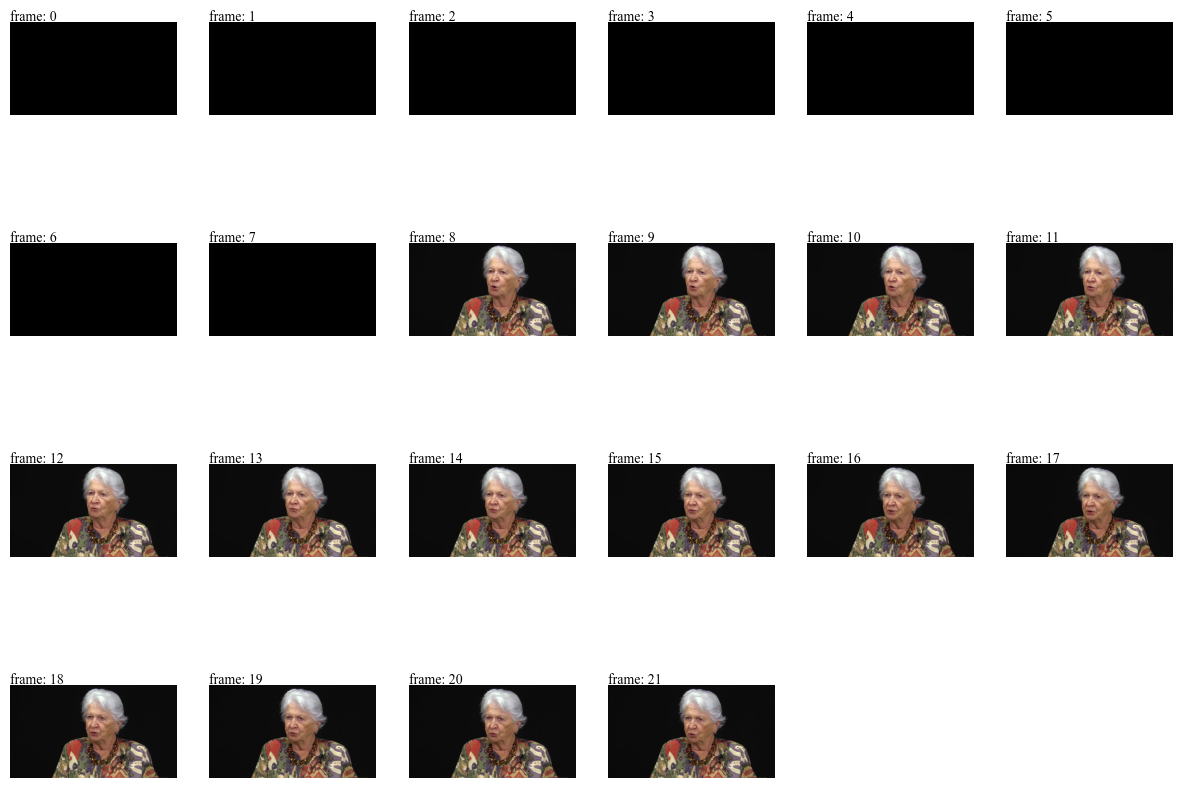

In [27]:
man_lab_fun.DISPLAY_FRAMES(video_frames, start_frame_crop, end_frame_crop, n_frames_per_row)

#### Proceed to create the labeled file

In [2]:
labeled_file_exists = int(str(INDEX_DT.loc[VIDEO_ID,'label_file_exist']))

if labeled_file_exists == 0:
    print('Creating Label File...')
    VD_MEASURE_DT['label_measures'] = str({})
    VD_LABELED_DT = VD_MEASURE_DT.copy()
else:
    print('Reading Label File...') 
    VD_LABELED_DT = man_lab_fun.READ_CSV_FILE(str(INDEX_DT.loc[VIDEO_ID,'path']).split()[2], fp.VD_LABELED_L0)

NameError: name 'INDEX_DT' is not defined

#### Select the current emotion to label and the measures that will be used to determine that emotion

In [30]:
# Type the Begin and End frames you want to label (By default label the section with the selected frames above)
init_frame_label = start_frame_crop
end_frame_label = end_frame_crop

# Prepare List and Dict
selected_class = 'neutral'
label_measure_insert = ["m1", "m3", "m12", "e1", "e2"]

# Just Insert
VD_LABELED_DT = man_lab_fun.UPDATE_LABEL_DF(init_frame_label, end_frame_label, selected_class, label_measure_insert, VD_LABELED_DT)

In [31]:
try:
    get_measure = man_lab_fun.GET_MEASURES_FROM_CLASS (VD_LABELED_DT, selected_class)
    print(get_measure)
except:
    print('Class not found')

['m1', 'm3', 'm12', 'e1', 'e2']


#### Check how the marking will be done at the final series

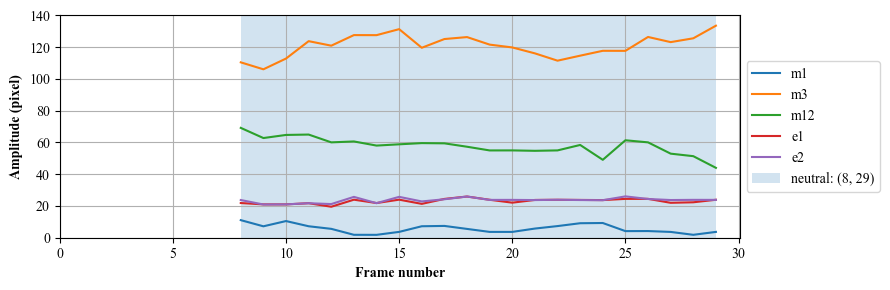

In [32]:
# Select the begin and end frame to be shown
start_frame = 0
end_frame = len(VD_LABELED_DT)

py.init_notebook_mode(connected=True)
plt.rcParams['font.size'] = 10
plt.rcParams["font.family"] = "Times New Roman"

man_lab_fun.PLOT_CLASS_GRAPH(VD_LABELED_DT, VD_MEASURE_DT_V2, selected_class, start_frame, end_frame)

#### Finally, mark the series with the emotion selected

In [33]:
VD_LABELED_DT.to_csv(os.path.join(VIDEO_FILE_PATH, fp.VD_LABELED_L0))